# Pricing of Maturity Monitored Barrier Security

This notebook prices the _"NBC Auto Callable Contingent Memory Income Note"_ described in this [link](https://nbcstructuredsolutions.ca/detailProduit.aspx?lequel=5317#documents).  This note is referred to as the _"security"_ for the remainder of this Notebook. 

This will be accomplished by first creating a function to generate the payout of the security if given the return of the underlying asset, which is the _Shares® Core S&P 500 Index ETF (CAD-Hedged)_.   This asset is referred to the _"ETF"_ for the remainder of the Notebook.

With this function defined we estimate the volatility of the ETF and then perform a Monte Carlo simulation of the ETF performance and the resulting security payout.  With the population of payout profiles we can estimate the fair price of the security.

## 1. Create the security payout function

#### Import some necessary modules.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set()

%matplotlib inline

#### Define some variables

In [2]:
barrier = -0.25      # Maturity-monitored barrier
coupon = 5.75 / 2    # Semi-annual coupon payment
call_threshold = 0.1 # Call threshold
face_value = 100     # Face value of the security
pf = 0.0             # Participation Factor
deferred_ppf = 0.05  # Deferred payment participation factor
current_ppf = 0.01   # Current payment participation factor
vrt = 0.0            # Variable return threshold

issue_date = pd.to_datetime(['2020-02-25'], infer_datetime_format=True)
feb_date = issue_date
mar_date = pd.to_datetime(['2020-03-03'], infer_datetime_format=True)
paydays = pd.to_datetime(['2020-08-18', '2021-02-18',
                          '2021-08-18', '2022-02-17',
                          '2022-08-18', '2023-02-17',
                          '2023-08-18', '2024-02-16',
                          '2024-08-19', '2025-02-18',
                          '2025-08-18', '2026-02-18',
                          '2026-08-18', '2027-02-18', '2027-02-25'], 
                           infer_datetime_format=True)

#### Calculate the discount factors for February 25 and March 3, 2020

These discount factors are for each of the 14 valuation dates plus the final maturity date relative to both February 25, 2020 and March 3, 2020.  The discount factors were calculated in the Excel file linked [here](fnen6800-pricing.xlsm).  These were based on Canadian bond price data from [MarketWatch](https://www.marketwatch.com/investing/bond) except for the 1-month T-Bill, whcih came from [YCharts](https://ycharts.com/indicators/canada_1_month_treasury_bill_yield).

In [3]:
# z is the discount factor for each payout
z_feb = np.array([[0.992410841, 0.985339460, 0.979546758, 0.973836715, 0.968077416, 0.962380888, 0.956621589, 
                   0.951538723, 0.946359581, 0.941292119, 0.936256007, 0.930587457, 0.924659311, 0.918391061, 0.918150635]])

z_mar = np.array([[0.994351969, 0.988777333, 0.984887707, 0.981114970, 0.976878483, 0.972688169, 0.968451682, 
                   0.964645576, 0.960760469, 0.956959137, 0.952684688, 0.948130959, 0.942959266, 0.936977959, 0.936748540]])

# f is the forward rate for each period between payouts (1st from start to 1st payout)
f_feb = np.array([1.5852, 1.4302, 1.1792, 1.1757, 1.1804, 1.1869, 1.1939, 
                  1.0773, 1.0739, 1.0797, 1.0729, 1.2146, 1.2781, 1.3604, 1.3652])/100.0

f_mar = np.array([1.2278, 1.1244, 0.7883, 0.7718, 0.8611, 0.8645, 0.8682, 
                  0.7963, 0.7941, 0.7973, 0.8953, 0.9583, 1.0939, 1.2727, 1.2769])/100.0

# t is the time from the evaluation date; Feb 25 or Mar 3
t_feb = np.array([0.480822, 0.980822, 1.480822, 1.978082, 2.480822, 2.978082, 3.480822, 
                  3.975342, 4.483562, 4.980822, 5.480822, 5.980822, 6.480822, 6.980822, 7.000000])

t_mar = np.array([0.461644, 0.961644, 1.461644, 1.958904, 2.461644, 2.958904, 3.461644, 
                  3.956164, 4.464384, 4.961644, 5.461644, 5.961644, 6.461644, 6.961644, 6.980822])

#### Test the payout function with the examples given in this [link](https://nbcstructuredsolutions.ca/_afficheDocument.aspx?doc=05317_EN_CLIENT_SUMMARY.pdf&secur=0&rnd=0.01401764).

In [4]:
sample_returns = np.array([[ -9, -41, -12, -42,   -46, -48, -46.5, -50,   -47, -45.5, -47,   -43, -49,   -50],
                           [ -5,  -3,   6, -10,   -41, -46, -41,    -9,   -20, -49,   -45.5, -44, -41.5, -15],
                           [ -5, -10,  -7, -13.5, -46, -50, -47,   -46.5, -47, -42,   -44,   -14,  -4,    35],
                           [-10, -14,  -4, -13,   -11,  25,   1,    50,   -40, -60,    -5,     5,  95,     5]]).T/100.0

expected_payout = np.zeros((sample_returns.shape[0] + 1, sample_returns.shape[1]))
expected_payout[0, 0] = 2.875
expected_payout[2, 0] = 6.40
expected_payout[-1, 0] = 50

expected_payout[[0, 1, 3, 8], 1] = 2.875
expected_payout[2, 1] = 2.935
expected_payout[7, 1] = 12.3
expected_payout[-2, 1] = 14.875
expected_payout[-1, 1] = 100

expected_payout[[0, 1, 2, 3, -3], 2] = 2.875
expected_payout[-4, 2] = 23.55
expected_payout[-2, 2] = 3.225 + 100

expected_payout[0:5, 3] = 2.875
expected_payout[5, 3] = 3.125 + 100

print('Sample Returns:')
print(sample_returns)
print('\nExpected Payout:')
print(expected_payout)


Sample Returns:
[[-0.09  -0.05  -0.05  -0.1  ]
 [-0.41  -0.03  -0.1   -0.14 ]
 [-0.12   0.06  -0.07  -0.04 ]
 [-0.42  -0.1   -0.135 -0.13 ]
 [-0.46  -0.41  -0.46  -0.11 ]
 [-0.48  -0.46  -0.5    0.25 ]
 [-0.465 -0.41  -0.47   0.01 ]
 [-0.5   -0.09  -0.465  0.5  ]
 [-0.47  -0.2   -0.47  -0.4  ]
 [-0.455 -0.49  -0.42  -0.6  ]
 [-0.47  -0.455 -0.44  -0.05 ]
 [-0.43  -0.44  -0.14   0.05 ]
 [-0.49  -0.415 -0.04   0.95 ]
 [-0.5   -0.15   0.35   0.05 ]]

Expected Payout:
[[  2.875   2.875   2.875   2.875]
 [  0.      2.875   2.875   2.875]
 [  6.4     2.935   2.875   2.875]
 [  0.      2.875   2.875   2.875]
 [  0.      0.      0.      2.875]
 [  0.      0.      0.    103.125]
 [  0.      0.      0.      0.   ]
 [  0.     12.3     0.      0.   ]
 [  0.      2.875   0.      0.   ]
 [  0.      0.      0.      0.   ]
 [  0.      0.      0.      0.   ]
 [  0.      0.     23.55    0.   ]
 [  0.      0.      2.875   0.   ]
 [  0.     14.875 103.225   0.   ]
 [ 50.    100.      0.      0.   ]]


#### Define the payout function

In [5]:
def get_payouts(returns, z):
    """
    Args:
        returns (np.array):  [n_dates, n_simulations] The ETF returns.
        z (np.array):  [1, n_dates + 1] Discount factors to be applied to the payout.
        
    Returns:
        np.array:  [n_dates + 1, n_simulations]  Payouts for valuation dates and maturity.
        np.array:  [n_simulations]  The present value of the payouts
    """
    n_dates = returns.shape[0]
    n_sims = returns.shape[1]

    # Determine the returns that are above the barrier (hits)
    hits = returns >= barrier
    miss = np.logical_not(hits)
    
    # Calculate the memory
    memory = np.zeros_like(returns)
    for i in range(1, n_dates):
        memory[i, :] = (memory[i - 1, :] + 1) * miss[i - 1, :]
    
    # Calculate deferred payment variable return if memory > 0
    deferred = (face_value * (returns - barrier) * deferred_ppf) * (memory > 0)
    
    # Calculate the Current Payment Variable Return
    variable = face_value * np.clip(returns - vrt, a_min=0.0, a_max=None) * current_ppf

    # Calculate the total coupon payment
    coupons = hits * (coupon * (memory + 1) + deferred) + variable
    del deferred, variable
    
    # Move all coupons upto call limit has been achieved to the payout array
    # Dummy created so argmax returns the size of the array if limit not volated
    payout = np.zeros((n_dates + 1, n_sims))
    dummy = np.vstack((returns, np.ones((1, n_sims)) * (call_threshold + 1)))
    hit_limit = np.argmax(dummy > call_threshold, axis=0) + 1
    del dummy
    for i in range(n_sims):
        h = min(hit_limit[i], n_dates)
        payout[:h, i] = coupons[:h, i]
    del coupons
    
    # Add the maturity Redemption Payment
    limit1 = min(call_threshold, 0.0)
    hit_limit -= 1
    for i in range(n_sims):
        if hit_limit[i] < n_dates:
            maturity_date_index = hit_limit[i]
            r = returns[hit_limit[i], i] 
        else:
            maturity_date_index = n_dates
            r = returns[-1, i] 

        if r > limit1:
            payout[maturity_date_index, i] = payout[maturity_date_index, i] + face_value * (1 + vrt)
        elif r >= barrier:
            payout[maturity_date_index, i] = payout[maturity_date_index, i] + face_value
        else:
            payout[maturity_date_index, i] = payout[maturity_date_index, i] + face_value * (1 + r)
    
    # Calculate present value of each simulation
    pv = z.dot(payout)
    
    return payout, pv[0, :]

# Run test
p, pv_feb = get_payouts(sample_returns, z_feb)
if np.max(np.abs(p - expected_payout)) > 0:
    print("Coupon error detected in test set.")
    print(p - expected_payout)
else:
    print("Exact match with test set!!\n")

print("PV = [{}]".format(", ".join(["${:.2f}".format(v) for v in pv_feb])))


Exact match with test set!!

PV = [$55.03, $131.26, $130.68, $113.33]


## 2. Estimate ETF Volatility

### 2.1 Estimate ETF Volatility from historical price data
We have downloaded the ETF, sticker `XSP.TO`, from [Yahoo Finance](https://ca.finance.yahoo.com/quote/XSP.TO/history?period1=1356998400&period2=1583539200&interval=1d&filter=history&frequency=1d) and will calculate the volatility form the adjusted close price data.  We download load the data from Dec 31, 2012 through March 6, 2020.  However we will calculate the volatility on the 7 year window prior to both February 25, 2020 and march 3, 2020.  We are also only using the adjusted close price data to accomindate splits and dividends.

#### Load the ETF price history

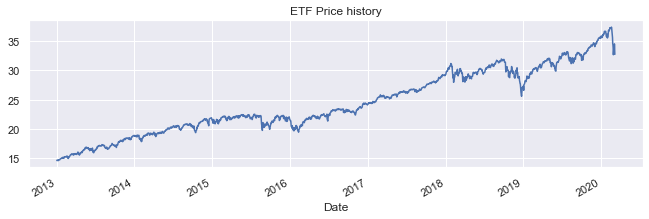

In [6]:
# Read the data from the CSV file downloaded from Yahoo Finance.
price = pd.read_csv('XSP.TO.csv', squeeze=True, index_col='Date', 
                    usecols=['Date', 'Adj Close'], parse_dates=True)

# Fill and missing data with a linear interpolation
price = price.replace(0, np.nan).interpolate()

# Make a pretty plot to ensure everything loaded properly
_ = price.plot(figsize=(11, 3))
plt.title("ETF Price history")
plt.show()

##### Calculate the log returns

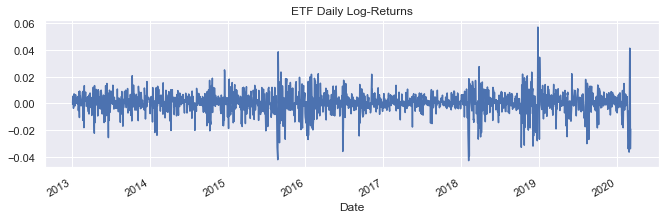

Prices:
Date
2013-01-02    14.656860
2013-01-03    14.648044
2013-01-04    14.727412
Name: Adj Close, dtype: float64

Returns:
Date
2013-01-03   -0.000602
2013-01-04    0.005404
Name: Adj Close, dtype: float64


In [7]:
returns = np.log(price) - np.log(price.shift(1))

# Make a pretty plot
_ = returns.plot(figsize=(11, 3))
plt.title("ETF Daily Log-Returns")
plt.show()

# Print out a couple returns to check the values manually
print("Prices:")
print(price.iloc[:3])
print("\nReturns:")
print(returns.iloc[1:3])


#### Calculate the Volatility over the previous 7 years for both Feb 25 and March 5, 2020.
Note we are annualizing the volatility by multiplying by $\sqrt{252}$ for 252 trading days per year.

In [8]:
feb_vol = returns['2013-02-25':'2020-2-24'].std()*np.sqrt(252)
mar_vol = returns['2013-03-3':'2020-3-2'].std()*np.sqrt(252)

print("Feb volatility = {:.3f}%".format(100*feb_vol))
print("Mar volatility = {:.3f}%".format(100*mar_vol))

Feb volatility = 12.944%
Mar volatility = 13.142%


For fun let's check volatility in the last month.

In [9]:
recent_vol = returns['2020-02-7':'2020-3-6'].std()*np.sqrt(252)
print("Recent volatility = {:.3f}%".format(recent_vol*100))

Recent volatility = 33.226%


### 2.2 Implied volatility
The implied volatility was calculated in the Excel file linked [here](fnen6800-pricing.xlsm) using data from [TMX](https://m-x.ca/nego_cotes_en.php?symbol=XSP*).

The implied volatilites were 11.5% and 13.4%, which is very close to the historical values of 12.9% (+1.4%) and 13.1% (-0.3%).  When we price the security, we will try both sets of volatilities to investigate the sensitivity.

## 3. Monte Carlo Pricing
Using the volatilities above we can now simulate the ETF to generate possible returns, then possible security payouts and then the average present value, which is the fair price.

#### Start by making a pretty plotting function of the payouts

In [32]:
def plot_etf(s, pvs, e_day):
    """
    Args:
        s(np.array):  [n_sims, n_days] The ERF price simulations to plot.
        pvs(np.array): [n_sims]  Present values of the security
        e-day (pd.datetime64):  The starting evaluation date.
    """
    
    m = s.shape[0]
    dates = np.concatenate((e_day, paydays.values[:-1]))
    
    # Setup figure
    plt.figure()
    left, width = 0.1, 1
    bottom, height = 0.1, 0.8
    left_h = left + width + 0.02
    rect_lines = [left, bottom, width, height]
    rect_histogram = [left_h, bottom, 0.2, height]
    # noinspection PyTypeChecker
    ax_lines = plt.axes(rect_lines)
    # noinspection PyTypeChecker
    ax_histogram = plt.axes(rect_histogram)

    # Make the line plots
    ns = 40
    for i in range(ns):
        ax_lines.plot(dates, s[i, :], lw=1.0)
    ax_lines.set(ylabel='ETF Price At Paydays',
                 title='ETF Simulations using Antithetic Variable Technique ({} of {:,.0f} plotted)'.format(ns, m))
    ax_lines.set_ylim((10, 70))

    # Make the histogram for the final stock prices S_T
    bins = np.arange(10, 70, 2)
    ax_histogram.hist(s[:, -1], bins=bins, orientation='horizontal')
    ax_histogram.set_ylim(ax_lines.get_ylim())
    ax_histogram.xaxis.set_major_formatter(NullFormatter())
    ax_histogram.yaxis.set_major_formatter(NullFormatter())
    ax_histogram.yaxis.set_label_position("right")
    ax_histogram.set(ylabel='Histogram of Final Prices')
    plt.show()

    # Make the histogram for the security present values
    plt.figure(figsize=(9, 3))
    plt.hist(pvs, bins=np.arange(0, 150, 5), density=True)
    plt.title("Security Present Value Distribution")
    plt.xlabel("Present Value")
    plt.ylabel("Probability")
    plt.show()


In [55]:
def monte_carlo(so, v, t, f, z, q, e_date, make_plot=False):
    """
    Args:
        so (float):  The starting ETF price.
        v(float):  Volatility of the ETF.
        t (np.array):  [n_days + 1]  Years from the evaluation date for each payout.
        f (np.array):  [n_days + 1]  Forward rate between payouts (1st from evaluation date).
        z (np.array):  [n_days + 1]  Discount factor for each payout.
        q (float):  Dividend yield of ETF.
        e-day (pd.datetime64):  The starting evaluation date.
        make_plot (boul):  Make some pretty plots if True.
    """
    
    # Set some internal parameters
    n = t.shape[0] - 1   # Number of time steps
    m = max(n*n, 50000)  # Number of simulations
    dt = np.insert(np.diff(t[:-1]), 0, t[0])
    
    # The drift term is deterministic so only need to calculate it once
    drift = (f[:-1] - q - 0.5*v*v)*dt
    
    # Create a n x m matrix of random variables
    random_term = np.random.normal(size=(m, n)) * np.sqrt(dt) * v

    # Generate the simulations using Antithetic Variable Technique
    prices_p = so * (np.hstack((np.ones((m ,1)), np.cumprod(np.exp(drift + random_term), axis=1))))
    prices_m = so * (np.hstack((np.ones((m ,1)), np.cumprod(np.exp(drift - random_term), axis=1))))
    
    # Calculate returns (Don't need return at start or maturity)
    returns_p = prices_p[:, 1:] / so - 1
    returns_m = prices_m[:, 1:] / so - 1

    # Calculate payouts and present values
    payouts_p, pvs_p = get_payouts(returns_p.T, z)
    payouts_m, pvs_m = get_payouts(returns_m.T, z)
    prices_both = np.vstack((prices_p, prices_m))
    
    # Calulate the expected present values
    price = (pvs_p.mean() + pvs_m.mean()) / 2.0    
    pvs_both = np.hstack((pvs_p, pvs_m)) 
    std_error = pvs_both.std() / np.sqrt(m)
    print("Expected Present Value = ${:.2f} (${:.2f}-${:.2f}), with a ${:.3f} standard error.".format(price, 
                                                                                                      pvs_both.min(), 
                                                                                                      pvs_both.max(),
                                                                                                      std_error))
    
    # Make pretty plot of ETF price evolution
    if make_plot:
        plot_etf(prices_both, pvs_both, e_date)


    return price 

#### Valuation at Feb 25, 2020

Expected Present Value = $106.33 ($24.19-$132.09), with a $0.088 standard error.


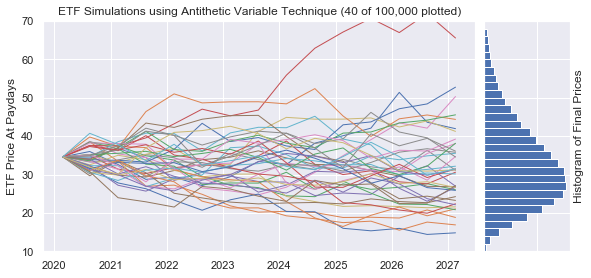

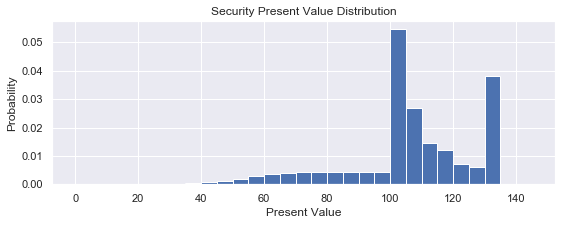

Wall time: 1.3 s


In [56]:
%%time
price_feb = monte_carlo(so=price['2020-02-25'], v=feb_vol, t=t_feb, f=f_feb, 
                          z=z_feb, q=0.017, e_date=feb_date, make_plot=True)

#### Valuation at March 3, 2020

Expected Present Value = $106.54 ($25.92-$134.47), with a $0.093 standard error.


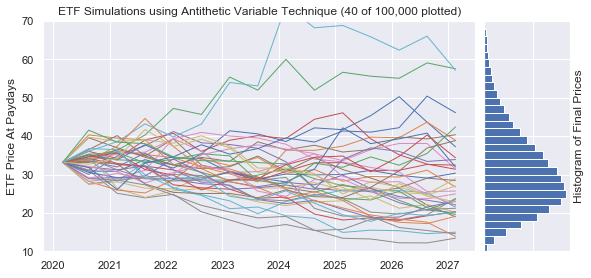

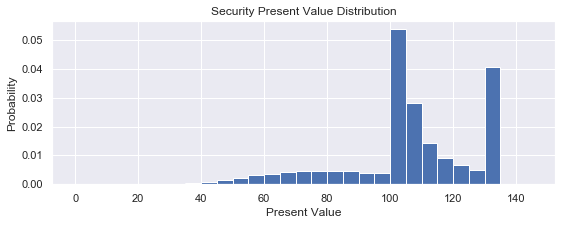

March price is $0.21 above February.


In [74]:
price_mar = monte_carlo(so=price['2020-03-03'], v=mar_vol, t=t_mar, f=f_mar, 
                          z=z_mar, q=0.017, e_date=mar_date, make_plot=True)
print("March price is ${:.2} above February.".format(price_mar - price_feb))

### Sensivity to volatility
Let's vary the volatility and see how the March prices change.

In [75]:
test_v = np.linspace(0.05, 0.35, 7)
prices_v = [monte_carlo(so=price['2020-03-03'], v=v, t=t_mar, f=f_mar, z=z_mar, q=0.017, e_date=mar_date) for v in test_v]

Expected Present Value = $127.28 ($65.06-$133.60), with a $0.046 standard error.
Expected Present Value = $112.76 ($31.03-$133.87), with a $0.083 standard error.
Expected Present Value = $103.86 ($20.36-$134.61), with a $0.099 standard error.
Expected Present Value = $98.53 ($9.21-$135.40), with a $0.113 standard error.
Expected Present Value = $94.33 ($5.78-$136.43), with a $0.128 standard error.
Expected Present Value = $91.26 ($2.79-$136.42), with a $0.140 standard error.
Expected Present Value = $88.31 ($1.12-$137.96), with a $0.152 standard error.


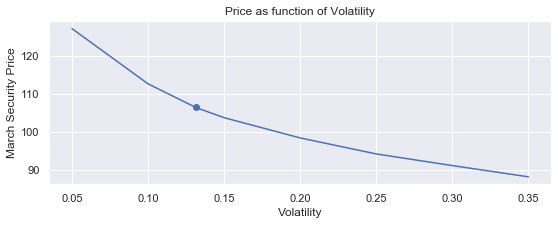

In [76]:
plt.figure(figsize=(9, 3))
plt.plot(np.insert(test_v, 2, mar_vol), np.insert(prices_v, 2, price_mar))
plt.scatter(mar_vol, price_mar)
plt.title("Price as function of Volatility")
plt.xlabel("Volatility")
plt.ylabel("March Security Price")
plt.show()

### Sensitivity to Dividend Yield
Let's vary the dividend yield to see how the price changes

In [77]:
test_q = np.linspace(0.013, 0.022, 7)
prices_q = [monte_carlo(so=price['2020-03-03'], v=mar_vol, t=t_mar, f=f_mar, z=z_mar, q=q, e_date=mar_date) for q in test_q]

Expected Present Value = $107.59 ($22.02-$134.51), with a $0.090 standard error.
Expected Present Value = $107.25 ($27.31-$134.29), with a $0.091 standard error.
Expected Present Value = $106.80 ($20.27-$134.35), with a $0.093 standard error.
Expected Present Value = $106.48 ($24.12-$134.31), with a $0.094 standard error.
Expected Present Value = $106.23 ($19.77-$134.59), with a $0.095 standard error.
Expected Present Value = $105.86 ($23.93-$134.82), with a $0.097 standard error.
Expected Present Value = $105.32 ($20.70-$134.33), with a $0.098 standard error.


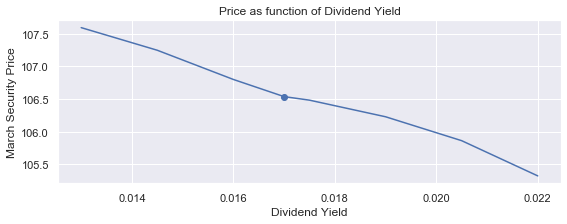

In [81]:
plt.figure(figsize=(9, 3))
plt.plot(np.insert(test_q, 3, 0.017), np.insert(prices_q, 3, price_mar))
plt.scatter(0.017, price_mar)
plt.title("Price as function of Dividend Yield")
plt.xlabel("Dividend Yield")
plt.ylabel("March Security Price")
plt.show()